
Reference:

https://www.kaggle.com/code/ammarnassanalhajali/k-fold-crossvalidation-coco-dataset-generator/notebook

https://www.kaggle.com/code/sagnik1511/uwmgit-data-preparation-from-scratch

In [1]:
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 KB 713.6 kB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - \ | / done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370075 sha256=b9b9bd6704221bb3ff218a23a496405fcda2fbbce2eddb68db4eb5fcec1dbdb6
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools


In [2]:
!pwd

/kaggle/working


In [3]:
import pycocotools
from pycocotools import mask
import json
import numpy as np
import pycocotools.mask as mask_util
from skimage import measure
import os
from tqdm import tqdm
from tqdm.notebook import tqdm
import cv2
import random
from itertools import groupby
import itertools
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from glob import glob
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *

In [4]:
!pwd

/kaggle/working


import the dataset to dataframe

In [5]:
# creating a dataframe
# path ="/content/uw-madison-gi-tract-image-segmentation/"
# path ="../projet 8/"
path ="../input/uw-madison-gi-tract-image-segmentation/"

dataset_path = os.path.abspath(path) 
csv_path = os.path.abspath(path+"train.csv")
df = pd.read_csv(csv_path)

def fetch_file_from_id(root_dir, case_id):
    case_folder = case_id.split("_")[0]
    day_folder = "_".join(case_id.split("_")[:2])
    file_starter = "_".join(case_id.split("_")[2:])
    # fetching folder paths
    folder = os.path.join(root_dir, case_folder, day_folder, "scans")
    # fetching filenames with similar pattern
    file = glob(f"{folder}/{file_starter}*")[0]
    # returning the first file, though it will always hold one file.
    return file

# df["segmentation"] = df["segmentation"].astype("str")
df["case_id"] = df["id"].apply(lambda x: x.split("_")[0][4:])
df["day_id"] = df["id"].apply(lambda x: x.split("_")[1][3:])
df["slice_id"] = df["id"].apply(lambda x: x.split("_")[-1])
df["path"] = df["id"].apply(lambda x: fetch_file_from_id(path+'/train', x))
df['path']=df.path.astype('str')
df['case_id']=df.case_id.astype('str')
df['slice_id']=df.slice_id.astype('str')
df["filename"] = df["path"].apply(lambda x: x.split('/')[-1])
df['unique_filename']  = df.apply(lambda row: str(row.case_id) +'_'+ str(row.day_id)+'_'+str(row.filename), axis=1)
df["height"] = df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[2]).astype("int")
df["width"] = df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[3]).astype("int")
df['size'] =df['height'].astype(str) +'x'+ df['width'].astype(str)

df.sample(5)


,id,class,segmentation,case_id,day_id,slice_id,path,filename,unique_filename,height,width,size
75779,case43_day26_slice_0124,stomach,NaN,43,26,0124,../input/uw-madison-gi-tract-image-segmentatio...,slice_0124_266_266_1.50_1.50.png,43_26_slice_0124_266_266_1.50_1.50.png,266,266,266x266
15395,case42_day17_slice_0092,stomach,20355 11 20618 20 20883 25 21148 28 21414 30 2...,42,17,0092,../input/uw-madison-gi-tract-image-segmentatio...,slice_0092_266_266_1.50_1.50.png,42_17_slice_0092_266_266_1.50_1.50.png,266,266,266x266
97864,case54_day35_slice_0030,small_bowel,NaN,54,35,0030,../input/uw-madison-gi-tract-image-segmentatio...,slice_0030_266_266_1.50_1.50.png,54_35_slice_0030_266_266_1.50_1.50.png,266,266,266x266
106244,case85_day27_slice_0087,stomach,31159 14 31516 22 31873 27 32231 31 32589 34 3...,85,27,0087,../input/uw-madison-gi-tract-image-segmentatio...,slice_0087_360_310_1.50_1.50.png,85_27_slice_0087_360_310_1.50_1.50.png,360,310,360x310
13617,case15_day0_slice_0076,large_bowel,13190 7 13453 13 13716 19 13980 23 14244 27 14...,15,0,0076,../input/uw-madison-gi-tract-image-segmentatio...,slice_0076_266_266_1.50_1.50.png,15_0_slice_0076_266_266_1.50_1.50.png,266,266,266x266


In [6]:
df.shape

(115488, 12)

In [7]:
df.dtypes

id                 object
class              object
segmentation       object
case_id            object
day_id             object
slice_id           object
path               object
filename           object
unique_filename    object
height              int64
width               int64
size               object
dtype: object

In [8]:
(df.notna().mean(axis=0)*100).sort_values(ascending=True)

segmentation        29.364956
id                 100.000000
class              100.000000
case_id            100.000000
day_id             100.000000
slice_id           100.000000
path               100.000000
filename           100.000000
unique_filename    100.000000
height             100.000000
width              100.000000
size               100.000000
dtype: float64

<AxesSubplot:>

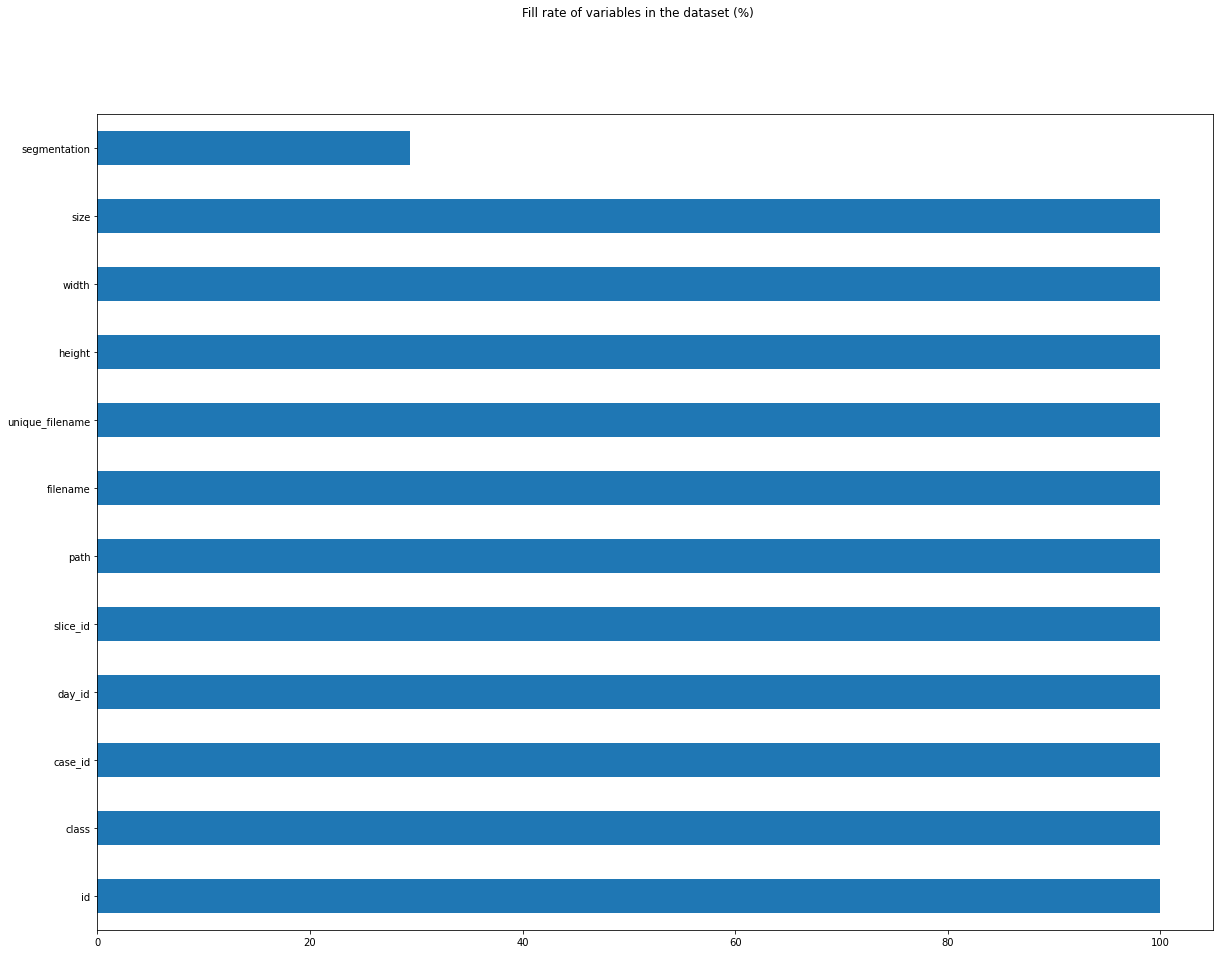

In [9]:
taux = (df.notna().mean(axis=0)*100).sort_values(ascending=False)
plt.suptitle("Fill rate of variables in the dataset (%)")
taux.plot(kind='barh', figsize=(20, 15))

In [10]:
df[df['segmentation'].isnull()].shape

(81575, 12)

In [11]:
df[df['segmentation'].notnull()].shape

(33913, 12)

In [12]:
df.dtypes

id                 object
class              object
segmentation       object
case_id            object
day_id             object
slice_id           object
path               object
filename           object
unique_filename    object
height              int64
width               int64
size               object
dtype: object

In [13]:
import warnings
warnings.simplefilter(action='ignore')

In [14]:
df_with_mask = df[df['segmentation'].notnull()] 
df_with_mask["segmentation"] = df["segmentation"].astype("str")
df_with_mask = df_with_mask.reset_index(drop=True)    
df_with_mask.head()

,id,class,segmentation,case_id,day_id,slice_id,path,filename,unique_filename,height,width,size
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,0065,../input/uw-madison-gi-tract-image-segmentatio...,slice_0065_266_266_1.50_1.50.png,123_20_slice_0065_266_266_1.50_1.50.png,266,266,266x266
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,123,20,0066,../input/uw-madison-gi-tract-image-segmentatio...,slice_0066_266_266_1.50_1.50.png,123_20_slice_0066_266_266_1.50_1.50.png,266,266,266x266
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,123,20,0067,../input/uw-madison-gi-tract-image-segmentatio...,slice_0067_266_266_1.50_1.50.png,123_20_slice_0067_266_266_1.50_1.50.png,266,266,266x266
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,123,20,0068,../input/uw-madison-gi-tract-image-segmentatio...,slice_0068_266_266_1.50_1.50.png,123_20_slice_0068_266_266_1.50_1.50.png,266,266,266x266
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,123,20,0069,../input/uw-madison-gi-tract-image-segmentatio...,slice_0069_266_266_1.50_1.50.png,123_20_slice_0069_266_266_1.50_1.50.png,266,266,266x266


In [15]:
df_with_mask.shape

(33913, 12)

Text(0.5, 1.0, 'repartition of case')

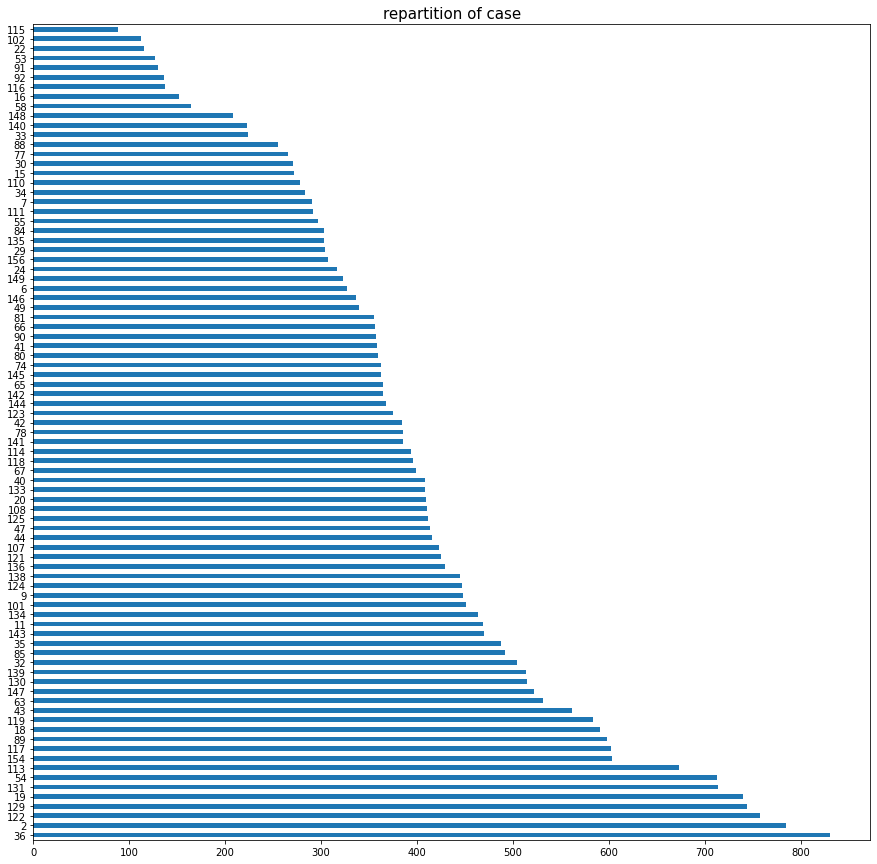

In [16]:
fig = plt.figure(figsize=(15, 15))
df_with_mask['case_id'].value_counts().plot(kind='barh')
plt.title(str('repartition of case'),fontsize=15)

Text(0.5, 1.0, 'repartition of days traitment')

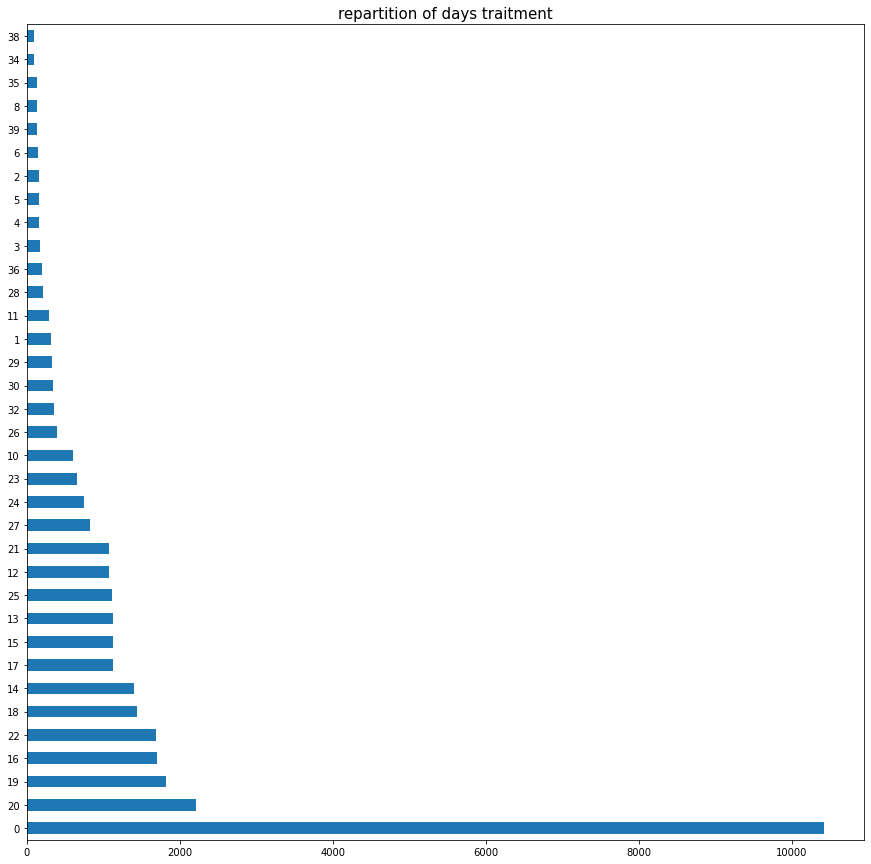

In [17]:
fig = plt.figure(figsize=(15, 15))
df_with_mask['day_id'].value_counts().plot(kind='barh')
plt.title(str('repartition of days traitment'),fontsize=15)

Text(0.5, 1.0, 'repartition of slice_id ')

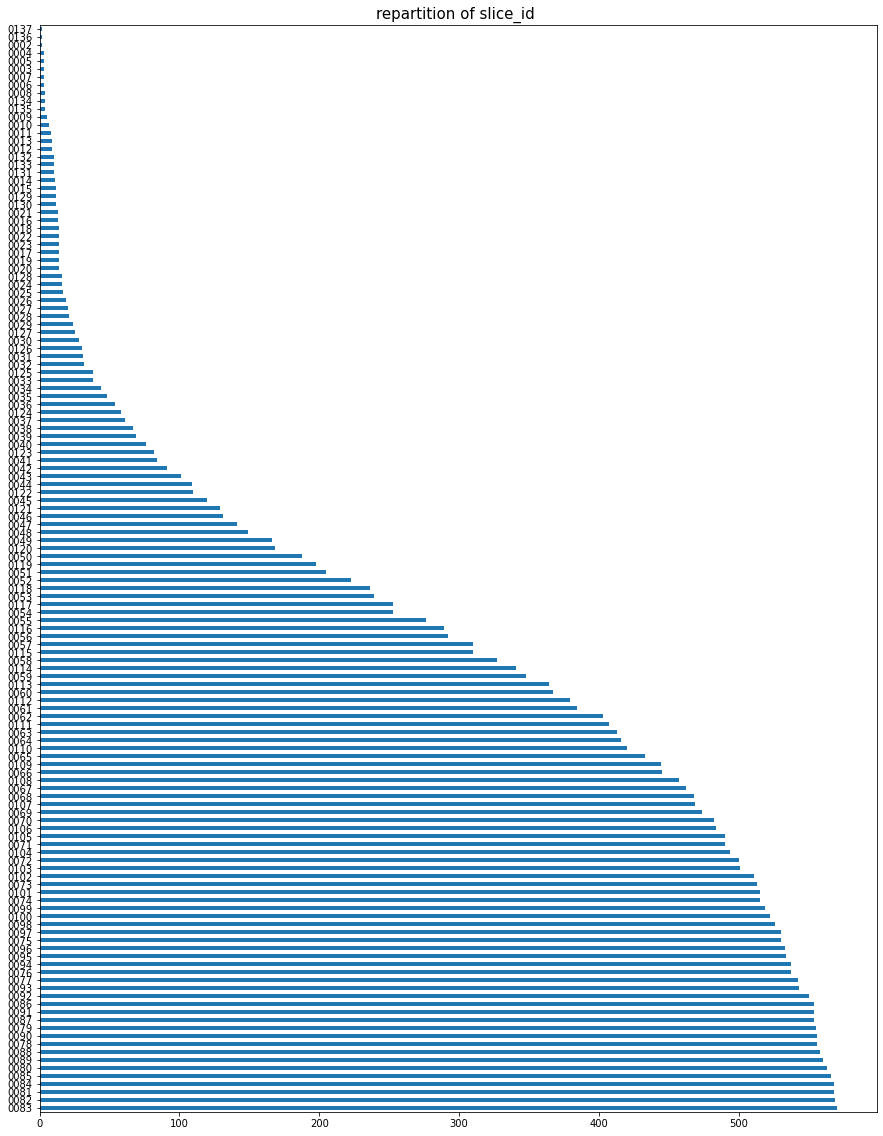

In [18]:
fig = plt.figure(figsize=(15, 20))
df_with_mask['slice_id'].value_counts().plot(kind='barh')
plt.title(str('repartition of slice_id '),fontsize=15)

In [19]:
pd.options.display.max_colwidth = 200
df_with_mask.path.head(1)[0]

'../input/uw-madison-gi-tract-image-segmentation//train/case123/case123_day20/scans/slice_0065_266_266_1.50_1.50.png'

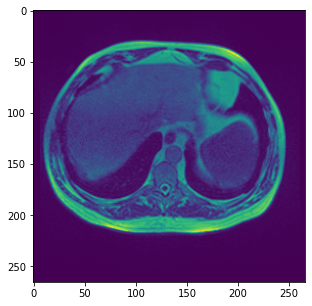

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig = plt.figure(figsize=(5, 5))
img = mpimg.imread(df_with_mask.path[0])
imgplot = plt.imshow(img)
plt.show()

In [21]:
df_with_mask.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33913 entries, 0 to 33912
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               33913 non-null  object
 1   class            33913 non-null  object
 2   segmentation     33913 non-null  object
 3   case_id          33913 non-null  object
 4   day_id           33913 non-null  object
 5   slice_id         33913 non-null  object
 6   path             33913 non-null  object
 7   filename         33913 non-null  object
 8   unique_filename  33913 non-null  object
 9   height           33913 non-null  int64 
 10  width            33913 non-null  int64 
 11  size             33913 non-null  object
dtypes: int64(2), object(10)
memory usage: 3.1+ MB


In [22]:
df_with_mask['size'].value_counts()

266x266    22328
360x310     9911
276x276     1557
234x234      117
Name: size, dtype: int64

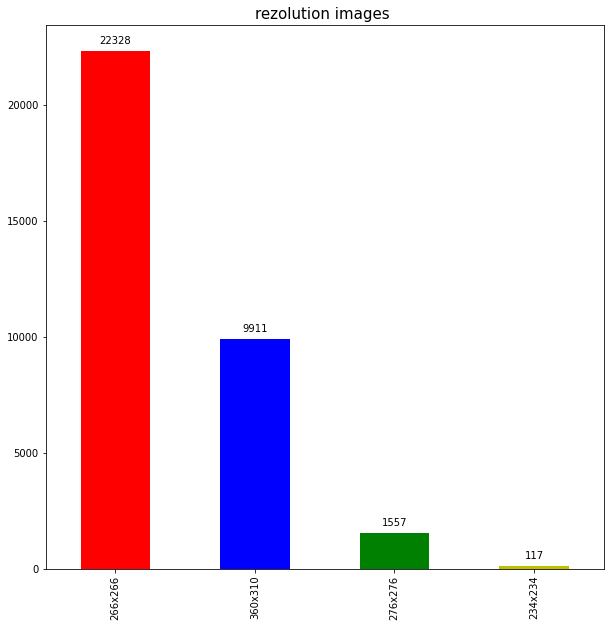

In [23]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = df_with_mask['size'].value_counts().plot(kind='bar', color=['r','b','g','y']) 

for p in ax.patches:
    ax.annotate(
                text=np.round(p.get_height(), decimals=2),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')
plt.title(str('rezolution images '),fontsize=15)
plt.show()

In [24]:
df_with_mask.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33913 entries, 0 to 33912
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               33913 non-null  object
 1   class            33913 non-null  object
 2   segmentation     33913 non-null  object
 3   case_id          33913 non-null  object
 4   day_id           33913 non-null  object
 5   slice_id         33913 non-null  object
 6   path             33913 non-null  object
 7   filename         33913 non-null  object
 8   unique_filename  33913 non-null  object
 9   height           33913 non-null  int64 
 10  width            33913 non-null  int64 
 11  size             33913 non-null  object
dtypes: int64(2), object(10)
memory usage: 3.1+ MB


In [25]:
df_with_mask['class'].value_counts()

large_bowel    14085
small_bowel    11201
stomach         8627
Name: class, dtype: int64

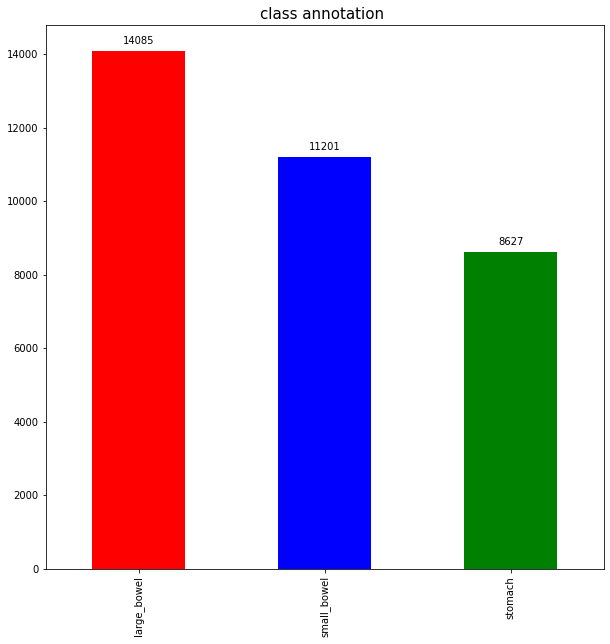

In [26]:
fig = plt.figure(figsize=(10, 10))
ax = df_with_mask['class'].value_counts().plot(kind='bar', color=['r','b','g']) 

for p in ax.patches:
    ax.annotate(text=np.round(p.get_height(), decimals=2),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')
plt.title(str('class annotation '),fontsize=15)
plt.show()

In [27]:
df.columns

Index(['id', 'class', 'segmentation', 'case_id', 'day_id', 'slice_id', 'path',
       'filename', 'unique_filename', 'height', 'width', 'size'],
      dtype='object')

<AxesSubplot:>

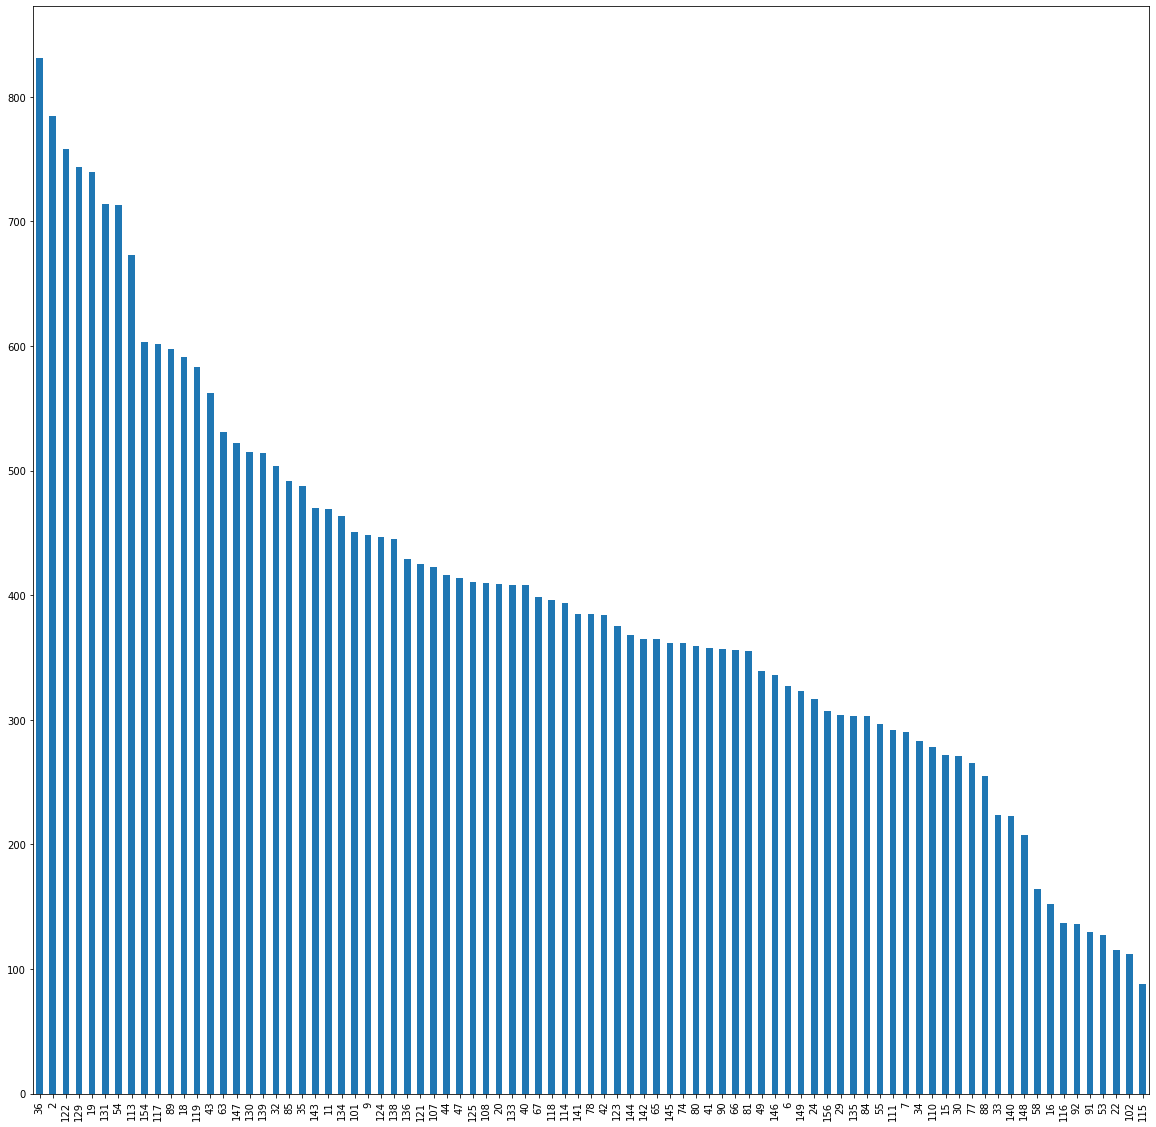

In [28]:
fig = plt.figure(figsize=(20, 20))
df_with_mask['case_id'].value_counts().plot(kind='bar')

<Figure size 2880x2880 with 0 Axes>

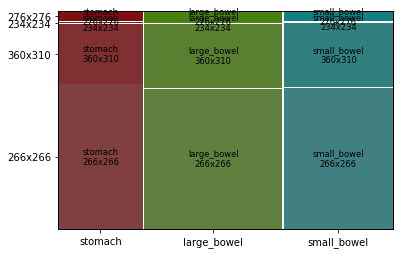

<Figure size 2880x2880 with 0 Axes>

In [29]:
from statsmodels.graphics.mosaicplot import mosaic

plt.rcParams['font.size'] = 10.0
mosaic(df_with_mask, ['class', 'size'], )
plt.figure(figsize=(40,40))

Text(0.5, 1.0, 'class annotation by case')

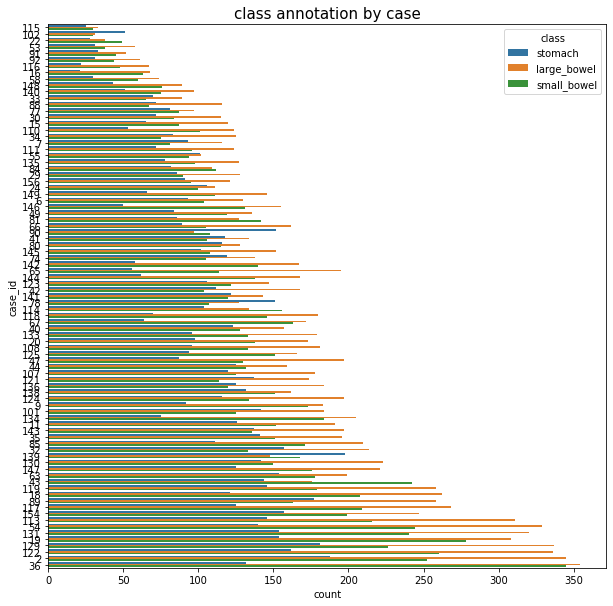

In [30]:
plt.figure(figsize=(10,10))
ordre_quartier = df_with_mask.groupby('case_id')['class'].count().sort_values().index
sns.countplot(y="case_id",hue="class",data=df_with_mask, order=ordre_quartier)
plt.title(str('class annotation by case'),fontsize=15)

In [31]:
df_with_mask.to_csv('/kaggle/working/madison.csv')

In [32]:
pd.options.display.max_colwidth = 50
df_with_mask[df_with_mask['id']=='case121_day0_slice_0107']

,id,class,segmentation,case_id,day_id,slice_id,path,filename,unique_filename,height,width,size
26418,case121_day0_slice_0107,large_bowel,16886 6 17148 13 17410 19 17673 30 17936 37 18...,121,0,0107,../input/uw-madison-gi-tract-image-segmentatio...,slice_0107_266_266_1.50_1.50.png,121_0_slice_0107_266_266_1.50_1.50.png,266,266,266x266
26419,case121_day0_slice_0107,small_bowel,21709 4 21972 11 22238 16 22503 21 22769 23 23...,121,0,0107,../input/uw-madison-gi-tract-image-segmentatio...,slice_0107_266_266_1.50_1.50.png,121_0_slice_0107_266_266_1.50_1.50.png,266,266,266x266


In [33]:
df_with_mask.shape

(33913, 12)

In [34]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

# From https://newbedev.com/encode-numpy-array-using-uncompressed-rle-for-coco-dataset
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle


# thanks to mohandass
# https://www.kaggle.com/code/mohanrobotics/cocoformat-dataset-creation-instance-segmentation
# i made some change to the id , the pycotools need numeric array id and not a string to work correctly
def create_coco_format_json(data_frame, classes, filepaths):
    images = []
    annotations = []
    categories = []
    count = 0
    
    # Additing categories
    for idx, class_ in enumerate(classes):
        categories.append(
            { 
                "id": idx,
                "name": class_
            }
        )
    i = 0
    for filepath in tqdm(filepaths):
        i += 1   
        image_id = i     
        file_id = ('_'.join((filepath.split("/")[-3] + "_" + filepath.split("/")[-1]).split("_")[:-4]))
        height_slice = int(filepath.split("/")[-1].split("_")[3])
        width_slice = int(filepath.split("/")[-1].split("_")[2])
        ids = data_frame.index[data_frame['id'] == file_id].tolist()
        # file_name = '/'.join(filepath.split("/")[2:])
        file_name = '/'.join(filepath.split("/")[3:])
        # print('/'.join(filepath.split("/")[2:]))
        if (len(ids) > 0):
            # Adding images which has annotations
            images.append(
                {
                    "id": image_id,
                    "file_id":file_id,#add id of the dataframe
                    "width":width_slice,
                    "height":height_slice,
                    "file_name": filepath
                }
            )
            for idx in ids:
                mk = rle_decode(data_frame.iloc[idx]['segmentation'], (height_slice, width_slice))
                ys, xs = np.where(mk)
                x1, x2 = min(xs), max(xs)
                y1, y2 = min(ys), max(ys)              
                contours,hierarchy = cv2.findContours(mk,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
                for id_, contour in enumerate(contours):
                    mask_image = np.zeros((mk.shape[0], mk.shape[1], 3),  np.uint8)
                    cv2.drawContours(mask_image, [contour], -1, (255,255,255), thickness=cv2.FILLED)
                    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
                    mask_image_bool = np.array(mask_image, dtype=bool).astype(np.uint8)
                    ys, xs = np.where(mask_image_bool)
                    x1, x2 = min(xs), max(xs)
                    y1, y2 = min(ys), max(ys)
                    enc =binary_mask_to_rle(mask_image_bool)
                    seg = {
                        'segmentation':enc, 
                        'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
                        'area': int(np.sum(mask_image_bool)),
                        'image_id':image_id, 
                        'category_id':classes.index(data_frame.iloc[idx]['class']), 
                        'iscrowd':0, 
                        'id': count
                    }
                    annotations.append(seg)
                    count +=1        
    # creating the dataset
    dataset_coco_format = {
        "categories": categories,
        "images": images,
        "annotations": annotations,
    }
    
    return dataset_coco_format

In [35]:
# Creation of train test split
train_df, test_df = train_test_split(df_with_mask, test_size=0.2)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# print(train_df.head())
print("\n \nNumber of Train Images:{}".format(len(train_df)))
print("Number of Test Images:{}".format(len(test_df)))


 
Number of Train Images:27130
Number of Test Images:6783


In [36]:
train_df.to_csv('./train_df.csv')
test_df.to_csv('./test_df.csv')

In [37]:
indexes = test_df['id'].value_counts().sort_values(ascending=False).to_frame().iloc[:1000,:].index

In [38]:
tmp_df = test_df[test_df['id'].isin(indexes)].sample(16)
tmp_df = tmp_df.reset_index(drop=True)
tmp_df.sort_values(['unique_filename']).sample(4)

,id,class,segmentation,case_id,day_id,slice_id,path,filename,unique_filename,height,width,size
3,case144_day14_slice_0091,large_bowel,25094 18 25358 21 25622 23 25886 25 26151 26 2...,144,14,0091,../input/uw-madison-gi-tract-image-segmentatio...,slice_0091_266_266_1.50_1.50.png,144_14_slice_0091_266_266_1.50_1.50.png,266,266,266x266
7,case55_day20_slice_0108,stomach,11845 3 12108 9 12371 13 12634 17 12899 18 131...,55,20,0108,../input/uw-madison-gi-tract-image-segmentatio...,slice_0108_266_266_1.50_1.50.png,55_20_slice_0108_266_266_1.50_1.50.png,266,266,266x266
0,case121_day16_slice_0097,large_bowel,15306 3 15570 8 15834 11 16099 14 16365 15 166...,121,16,0097,../input/uw-madison-gi-tract-image-segmentatio...,slice_0097_266_266_1.50_1.50.png,121_16_slice_0097_266_266_1.50_1.50.png,266,266,266x266
1,case108_day0_slice_0057,large_bowel,19566 13 19829 20 20094 23 20359 26 20624 29 2...,108,0,0057,../input/uw-madison-gi-tract-image-segmentatio...,slice_0057_266_266_1.50_1.50.png,108_0_slice_0057_266_266_1.50_1.50.png,266,266,266x266


In [39]:
classes = ['small_bowel', 'large_bowel', 'stomach']
tmp_json = create_coco_format_json(tmp_df, classes, tmp_df['path'].tolist())

100%|██████████| 16/16 [00:00<00:00, 30.85it/s]


In [40]:
# Code taken from: https://stackoverflow.com/a/65151218/12890869
def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

with open('./tmp_json.json', 'w', encoding='utf-8') as f:
    json.dump(tmp_json, f, ensure_ascii=True, indent=4, default=np_encoder)        

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


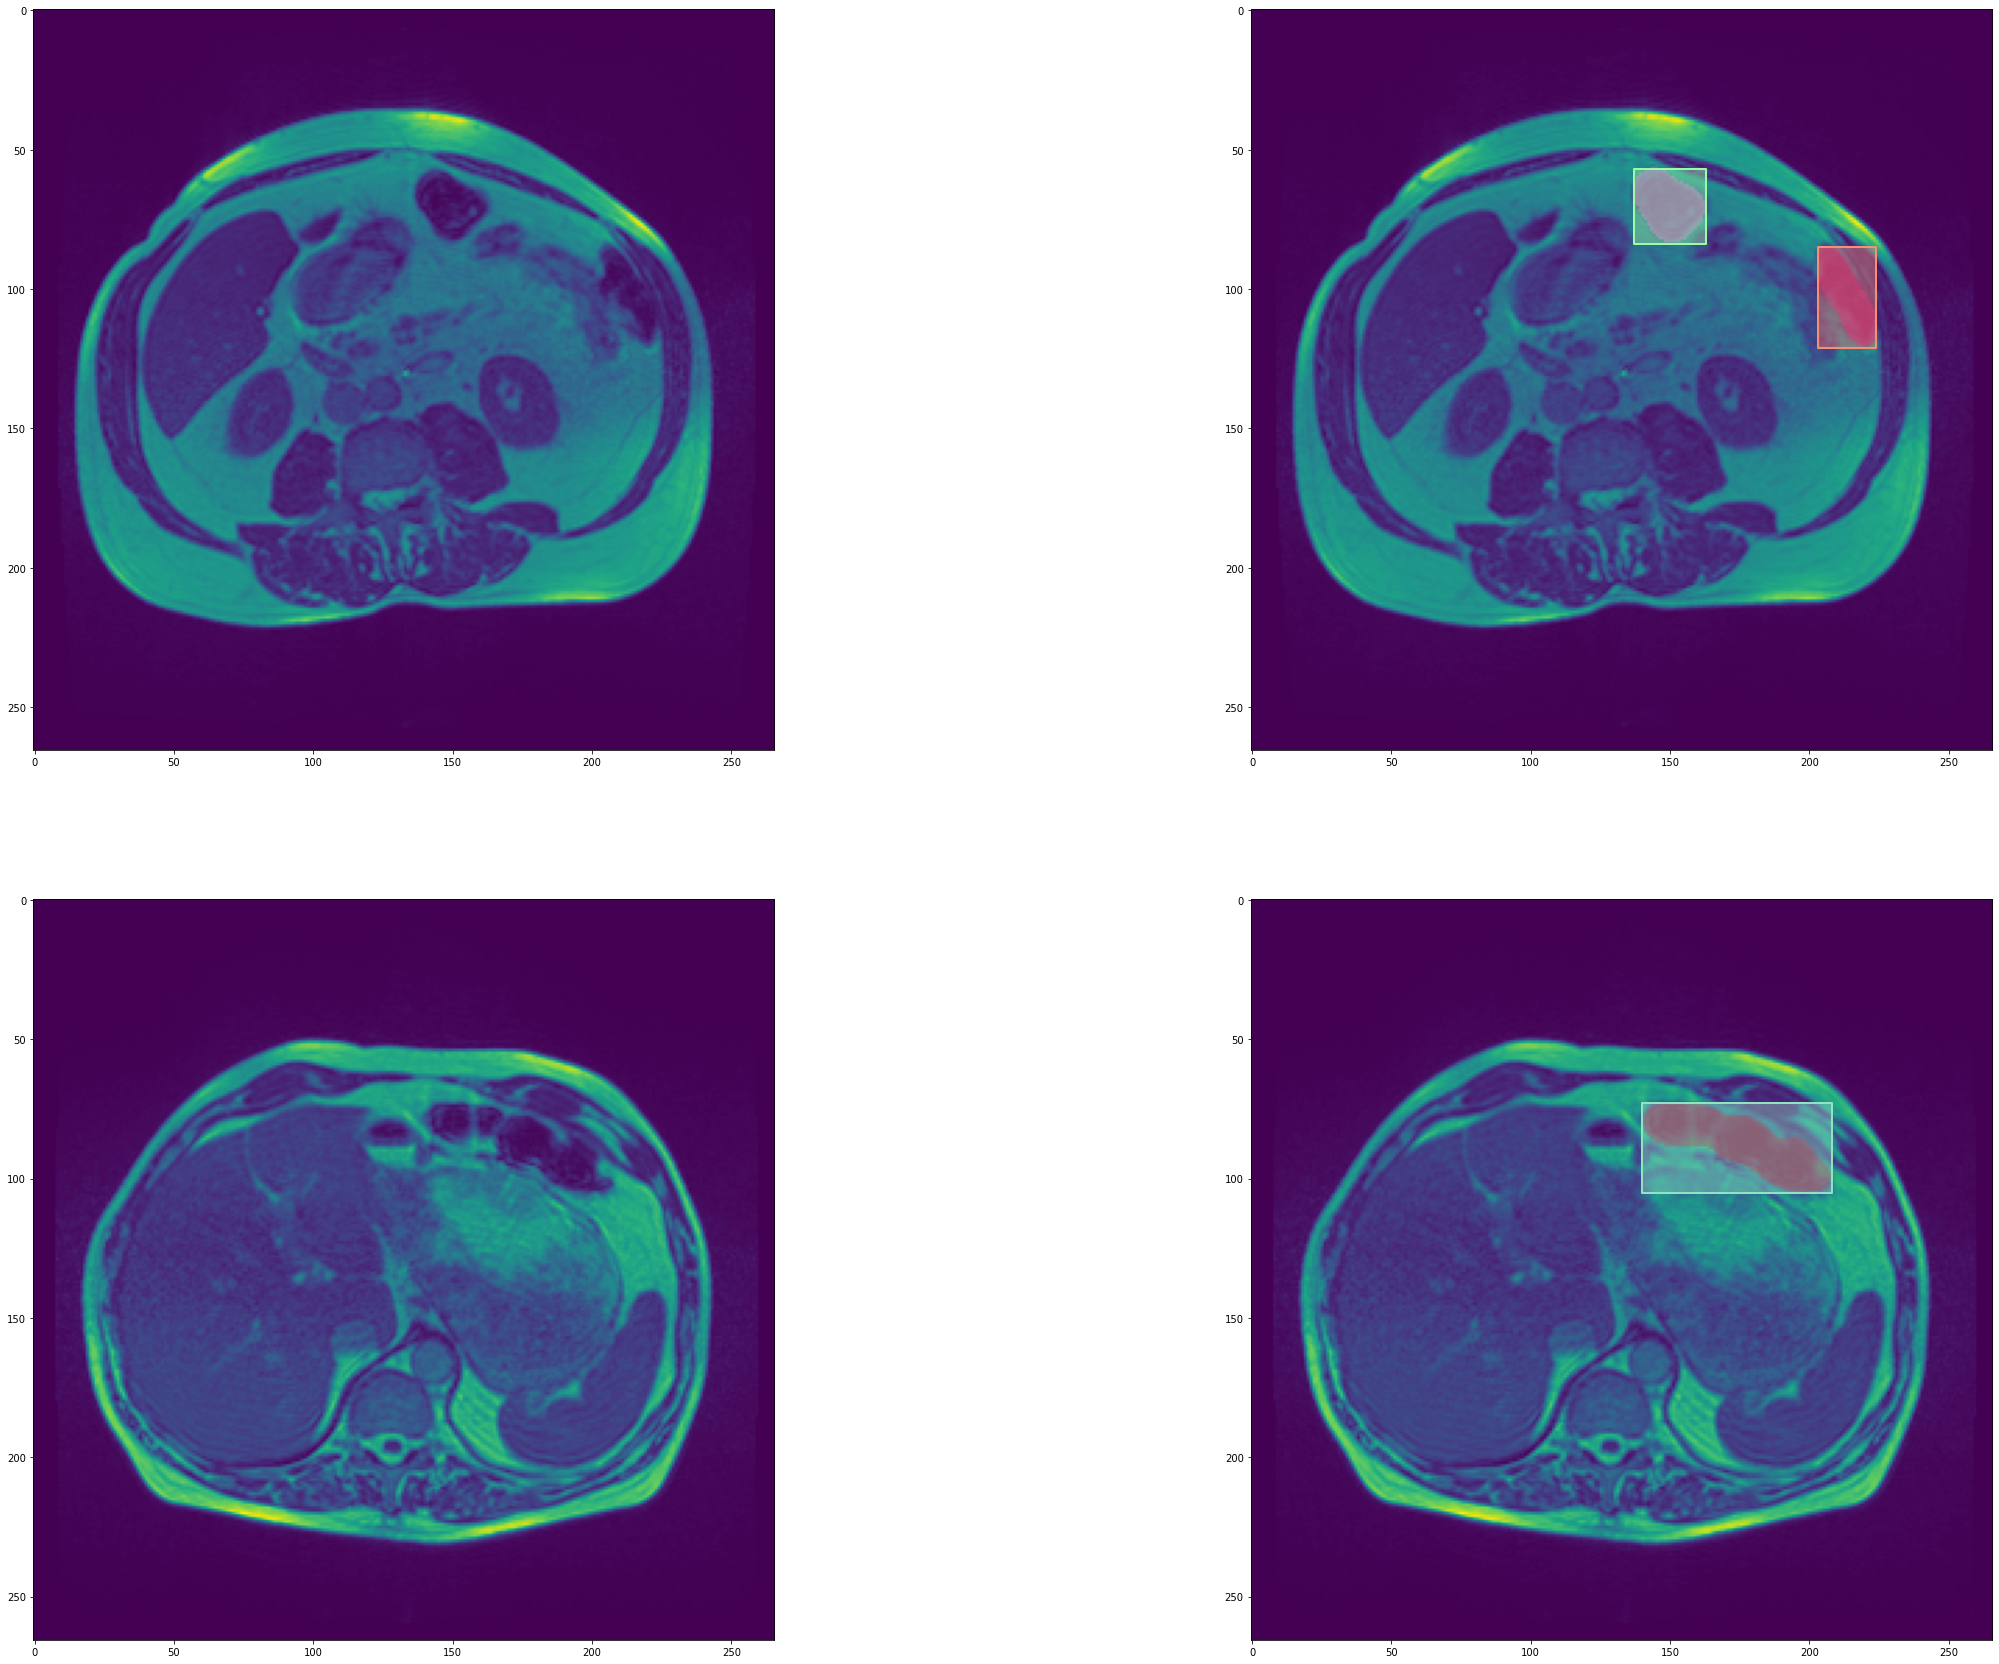

In [41]:
from pathlib import Path
annFile = Path(f'./tmp_json.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()


imgs = coco.loadImgs(imgIds[0:2])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.fromarray(np.array(Image.open(img['file_name'])).astype("uint16"))
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

In [42]:
import pandas as pd
info = coco.dataset

for k, v in info.items():
    if isinstance(v, int):
        info[k] = [v]
dataframe = pd.DataFrame.from_dict(info, orient='index')
dataframe

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
categories,"{'id': 0, 'name': 'small_bowel'}","{'id': 1, 'name': 'large_bowel'}","{'id': 2, 'name': 'stomach'}",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
images,"{'id': 1, 'file_id': 'case121_day16_slice_0097...","{'id': 2, 'file_id': 'case108_day0_slice_0057'...","{'id': 3, 'file_id': 'case131_day0_slice_0081'...","{'id': 4, 'file_id': 'case144_day14_slice_0091...","{'id': 5, 'file_id': 'case36_day10_slice_0100'...","{'id': 6, 'file_id': 'case148_day20_slice_0093...","{'id': 7, 'file_id': 'case136_day25_slice_0083...","{'id': 8, 'file_id': 'case55_day20_slice_0108'...","{'id': 9, 'file_id': 'case133_day0_slice_0060'...","{'id': 10, 'file_id': 'case118_day16_slice_006...",...,None,None,None,None,None,None,None,None,None,None
annotations,"{'segmentation': {'counts': [54085, 12, 253, 1...","{'segmentation': {'counts': [36504, 8, 256, 11...","{'segmentation': {'counts': [37319, 2, 262, 7,...","{'segmentation': {'counts': [77346, 2, 11, 3, ...","{'segmentation': {'counts': [48555, 2, 260, 8,...","{'segmentation': {'counts': [11041, 10, 252, 1...","{'segmentation': {'counts': [14741, 3, 261, 7,...","{'segmentation': {'counts': [56783, 5, 260, 9,...","{'segmentation': {'counts': [15815, 6, 259, 8,...","{'segmentation': {'counts': [67438, 1, 307, 5,...",...,"{'segmentation': {'counts': [40780, 4, 261, 9,...","{'segmentation': {'counts': [36823, 8, 257, 10...","{'segmentation': {'counts': [48433, 5, 270, 7,...","{'segmentation': {'counts': [37679, 5, 304, 7,...","{'segmentation': {'counts': [95331, 3, 305, 9,...","{'segmentation': {'counts': [92830, 6, 300, 11...","{'segmentation': {'counts': [40414, 6, 302, 10...","{'segmentation': {'counts': [71413, 2, 305, 8,...","{'segmentation': {'counts': [58068, 5, 304, 7,...","{'segmentation': {'counts': [38707, 10, 254, 1..."


In [43]:
classes = ['small_bowel', 'large_bowel', 'stomach']

train_json = create_coco_format_json(train_df, classes, train_df['path'].tolist())
test_json = create_coco_format_json(test_df, classes, test_df['path'].tolist())

100%|██████████| 6783/6783 [05:28<00:00, 20.67it/s]


In [44]:
with open('./train_json.json', 'w', encoding='utf-8') as f:
    json.dump(train_json, f, ensure_ascii=True, indent=4, default=np_encoder)   
    
with open('./test_json.json', 'w', encoding='utf-8') as f:
    json.dump(test_json, f, ensure_ascii=True, indent=4, default=np_encoder)

In [45]:
train_json = json.load(open('./train_json.json', 'r'))
test_json = json.load(open('./test_json.json', 'r'))

In [46]:
IMAGE_TRAIN_DIR = './'
ANNOTATION_FILE_VAL = (IMAGE_TRAIN_DIR+'test_json.json')
ANNOTATION_FILE_TRAIN = (IMAGE_TRAIN_DIR+'train_json.json')

coco_train = COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds() 
imgIds_train = coco_train.getImgIds() 
imgDict_train = coco_train.loadImgs(imgIds_train) 
print(len(imgIds_train) , len(catIds_train))

coco_val = COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds()
imgIds_val = coco_val.getImgIds()
imgDict_val = coco_val.loadImgs(imgIds_val)
print(len(imgIds_val) , len(catIds_val))

loading annotations into memory...
Done (t=3.99s)
creating index...
index created!
27130 3
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
6783 3


case113_day0_slice_0081
case24_day24_slice_0085
case42_day19_slice_0108
case116_day0_slice_0095


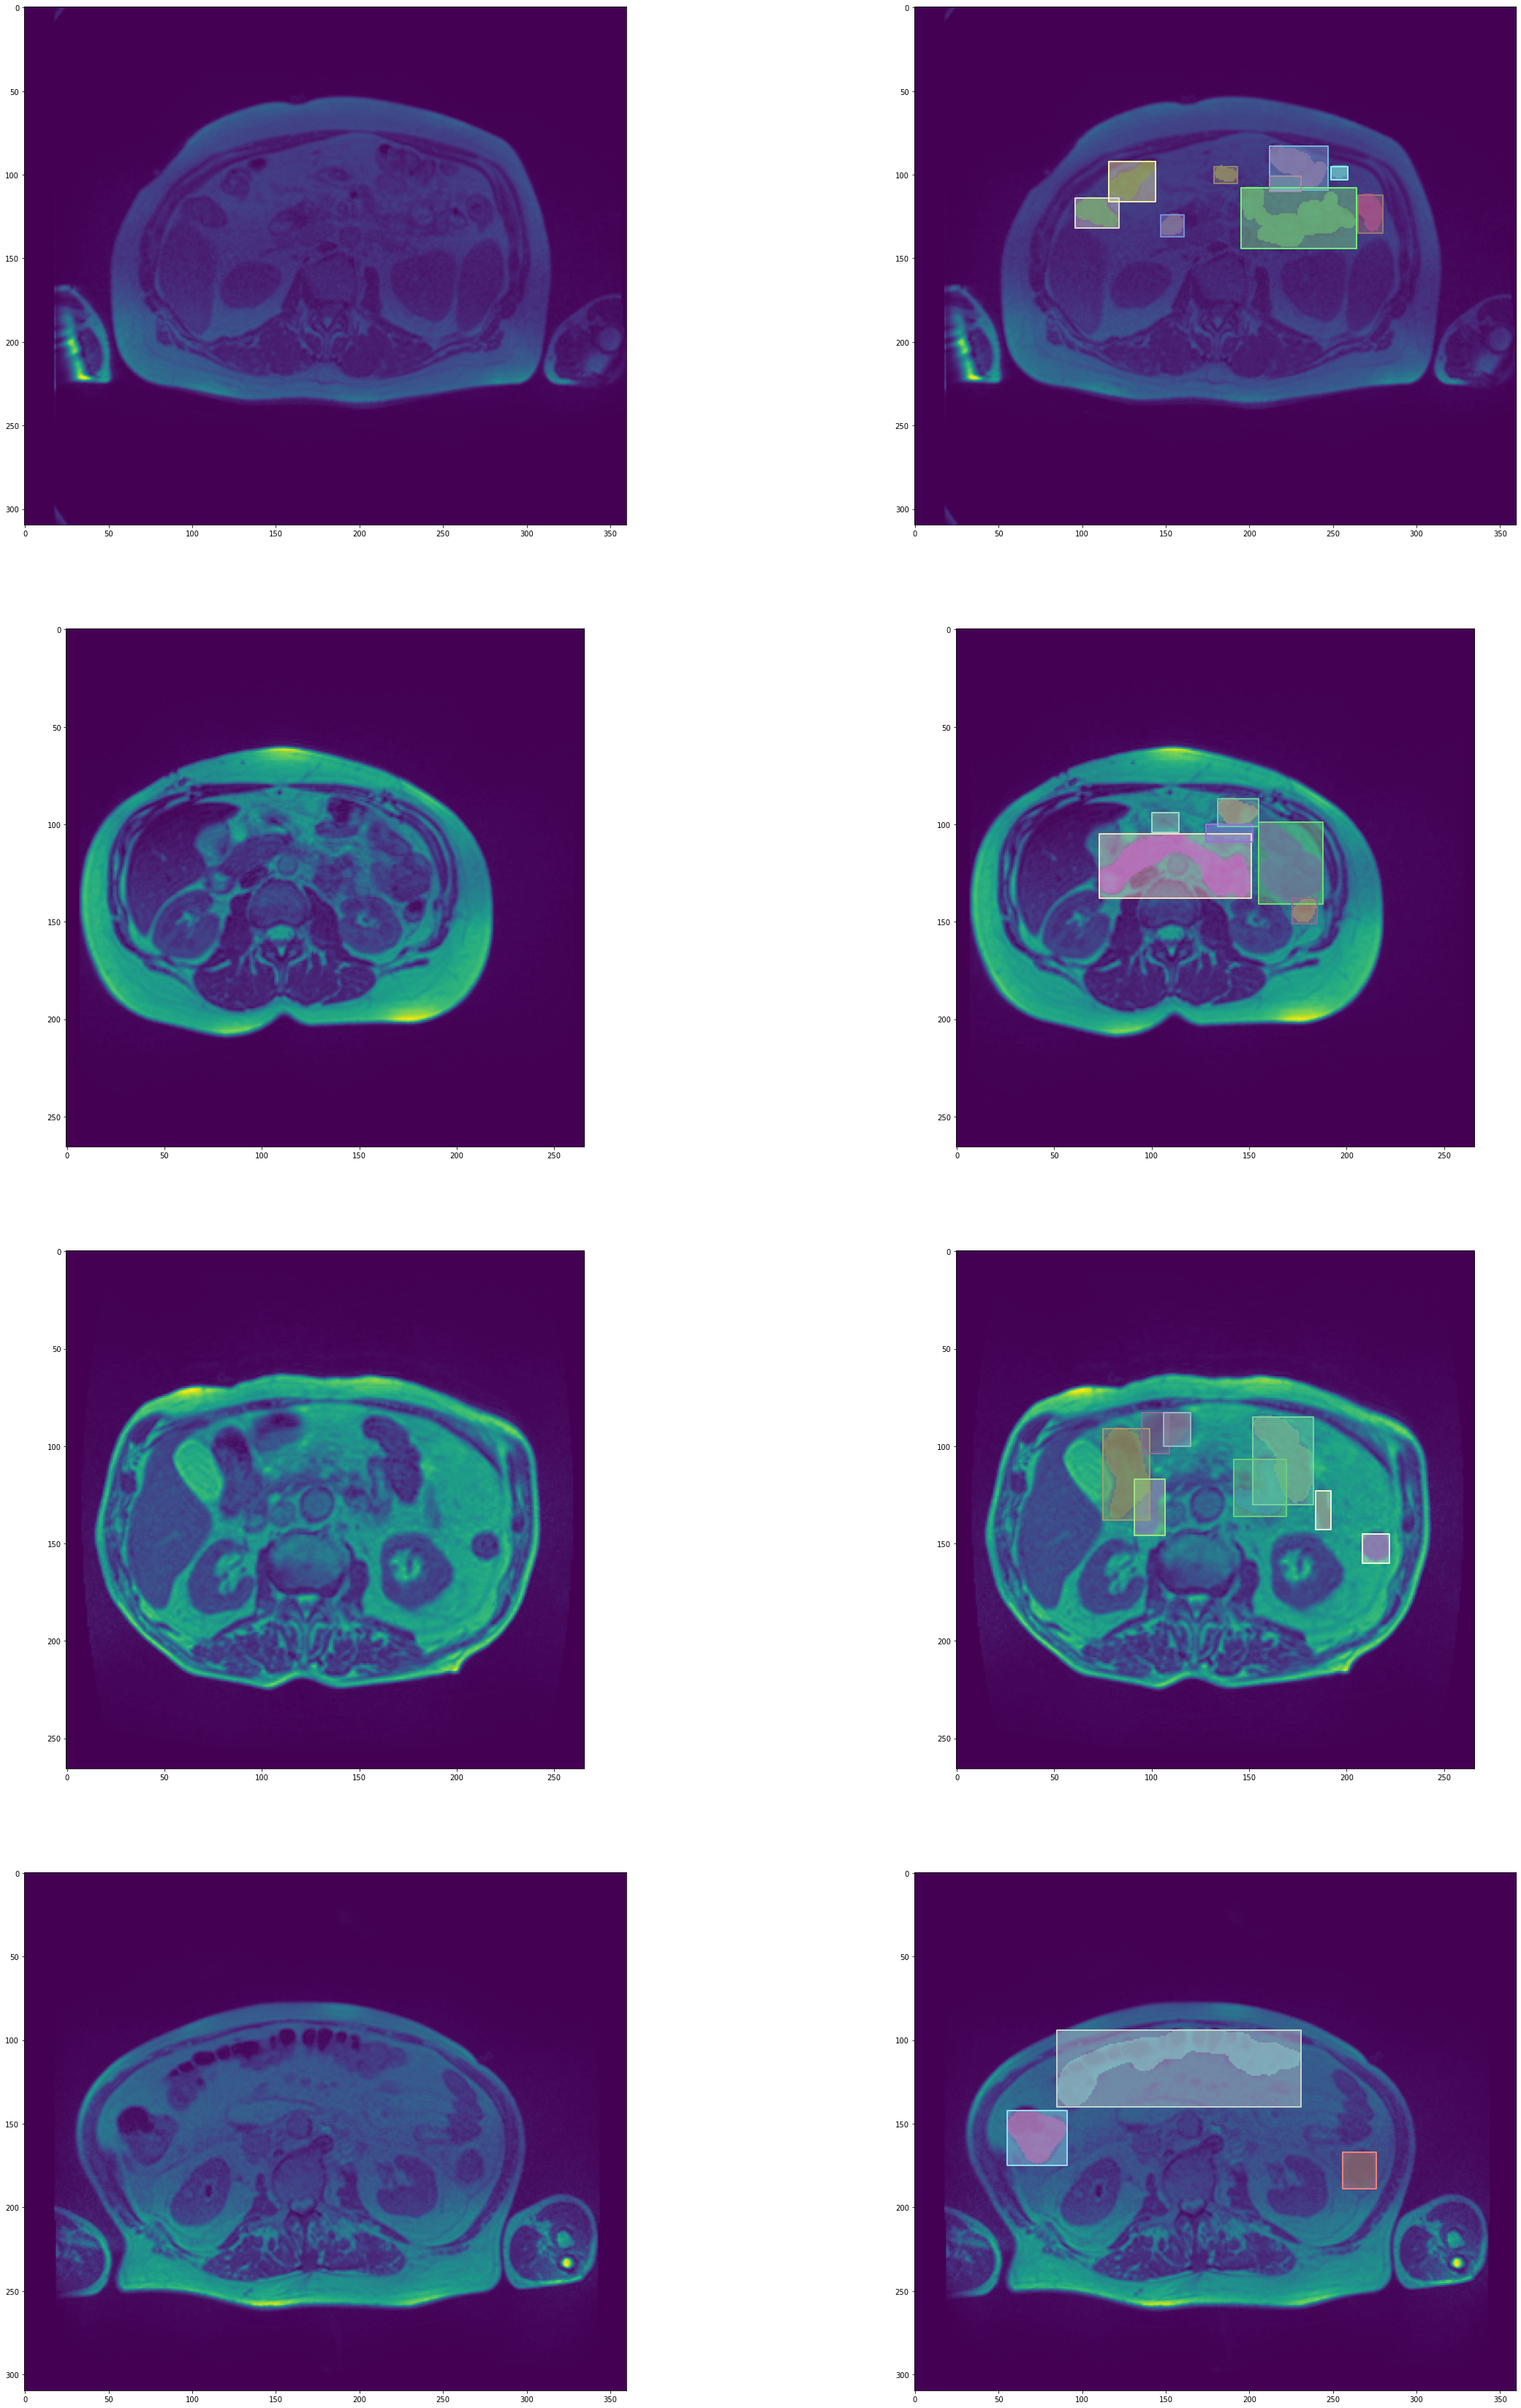

In [47]:
imgs = coco_train.loadImgs(imgIds_train[0:4])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    print(img['file_id'])
    I = Image.open(img['file_name'])
    I = Image.fromarray(np.array(Image.open(img['file_name'])).astype("uint16"))
    annIds = coco_train.getAnnIds(imgIds=[img['id']])
    anns = coco_train.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco_train.showAnns(anns, draw_bbox=True)